In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

os.environ['CUDA_VISIBLE_DEVICES'] = '/gpu:0'
print(tf.__version__)
print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)
matplotlib 3.1.1
numpy 1.16.5
pandas 0.25.2
sklearn 0.21.3
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
tf.test.is_gpu_available()

False

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
# print(fashion_mnist)
(x_train_all,y_train_all),(x_test,y_test) = fashion_mnist.load_data()
x_valid,x_train = x_train_all[:5000],x_train_all[5000:]
y_valid,y_train = y_train_all[:5000],y_train_all[5000:]
# 打印格式
print(x_valid.shape,y_valid.shape)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)


(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [4]:
# 数据归一化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train:[None,28,28] -> [None,784]
x_train_scaled = scaler.fit_transform(x_train.astype(np.float32).reshape(-1,1)).reshape(-1,28,28,1)
x_valid_scaled = scaler.transform(x_valid.astype(np.float32).reshape(-1,1)).reshape(-1,28,28,1)
x_test_scaled = scaler.transform(x_test.astype(np.float32).reshape(-1,1)).reshape(-1,28,28,1)

In [5]:
# tf.keras.models.Sequential()
# 构建模型
model = keras.models.Sequential()

# 卷积神经网络
model.add(keras.layers.Conv2D(filters=32,kernel_size=3,padding="same",activation='relu',input_shape=(28,28,1)))
model.add(keras.layers.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.Conv2D(filters=64,kernel_size=3,padding="same",activation='relu'))
model.add(keras.layers.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.Conv2D(filters=128,kernel_size=3,padding="same",activation='relu'))
model.add(keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

# 展平
model.add(keras.layers.Flatten())

# 全连接层
model.add(keras.layers.Dense(128,activation='relu'))

# 输出层
model.add(keras.layers.Dense(10,activation="softmax"))



# 
model.compile(loss='sparse_categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         7

In [7]:
# 回调函数 Tensorboard(文件夹）\earylystopping\ModelCheckpoint（文件名）
logdir = os.path.join("cnn-selu-callbacks")
print(logdir)
if not os.path.exists(logdir):
    os.mkdir(logdir)
# 文件名
output_model_file = os.path.join(logdir,"fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3),
]
# 开始训练
history = model.fit(x_train_scaled,y_train,epochs=10,validation_data=(x_valid_scaled,y_valid),callbacks=callbacks)

cnn-selu-callbacks
Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 135s 2ms/sample - loss: 0.7578 - accuracy: 0.7279 - val_loss: 0.4962 - val_accuracy: 0.8156
Epoch 2/10
55000/55000 [==============================] - 180s 3ms/sample - loss: 0.4123 - accuracy: 0.8481 - val_loss: 0.3637 - val_accuracy: 0.8698
Epoch 3/10
55000/55000 [==============================] - 246s 4ms/sample - loss: 0.3457 - accuracy: 0.8729 - val_loss: 0.3898 - val_accuracy: 0.8502
Epoch 4/10
55000/55000 [==============================] - 249s 5ms/sample - loss: 0.3112 - accuracy: 0.8855 - val_loss: 0.3003 - val_accuracy: 0.8932
Epoch 5/10
55000/55000 [==============================] - 248s 5ms/sample - loss: 0.2875 - accuracy: 0.8938 - val_loss: 0.2886 - val_accuracy: 0.8930
Epoch 6/10
55000/55000 [==============================] - 246s 4ms/sample - loss: 0.2663 - accuracy: 0.9021 - val_loss: 0.2985 - val_accuracy: 0.8918
Epoch 7/10
55000/55000 [========

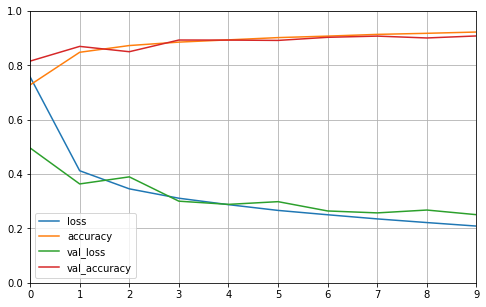

In [8]:
# 画图
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
plot_learning_curves(history)

# 损失函数，刚开始下降慢的原因
# 1. 参数众多，训练不充分
# 2. 梯度消失 -》 链式法则中
# 解决： selu缓解梯度消失

In [9]:
model.evaluate(x_test_scaled,y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.26908308988809587, 0.903]